# Analyzing Models and Tuning Hyper Parameters

## This notebook takes a stab at identifying which model to use in production

First, I import some dependencies for data manipulation; for numerical computations; for plotting charts; and finally, for a whole bunch of machine learning classification and text vectorization.

In [20]:
# Manipulates data
import pandas as pd
import re

# Performs numerical computations
import numpy as np

# Plotting charts
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Machine Learning things 
# The vectorizers are for performing analysis on word counts/frequencies
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# These are for classification and statistical analysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

Next I will load in JSON files of the subreddit posts for text analysis

In [21]:
sm = pd.read_json("../data_fetching/json2/SequelMemes.json")
pm = pd.read_json("../data_fetching/json2/PrequelMemes.json")

I will grab the posts' titles, create a feature for identifying whether a post came from r/SequelMemes, and create a corpus for vectorizing (getting word counts and frequencies for machine learning purposes).

In [22]:
sm_titles = sm[["title"]]
pm_titles = pm[["title"]]

sm_titles["is_sequel_meme"] = 1
pm_titles["is_sequel_meme"] = 0

meme_titles = pd.concat([pm_titles,sm_titles])
corpus = [title[0] for title in meme_titles[["title"]].values]

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


This is an attempt to create Pipelines and Feature Unions without using [Pipelines and Feature Unions](http://scikit-learn.org/stable/modules/pipeline.html).

I am not skilled enough (yet) to understand the intricacies of pipelines and feature unions; however, I can create the data structures I need to get something going.

I am basically testing every variation of of every parameter that can be passed into a CountVectorizer and TfidfVectorizer and then testing those against as many classifiers as I can. Ultimately, I pare down the classifiers either because some of them ran too slowly or froze my computer.

In [23]:
vectorizers_start = {
    "cvec" : CountVectorizer,
    "tfidf" : TfidfVectorizer,
}

vectorizers = {}

for key,vec in vectorizers_start.items():
    vectorizers[key] = vec(stop_words='english')
    for max_df in (0.25, 0.5, 0.75):
        vectorizers[f"{key}__max_df_of_{max_df}"] = vec(stop_words='english', max_df=max_df)
        for n_gram_range in [(1, 1), (1, 2), (1, 3), (1, 4)]:
            vectorizers[f"{key}__n_gram_range_of_{n_gram_range}"] = vec(stop_words='english', ngram_range=n_gram_range)
            vectorizers[f"{key}__n_gram_range_of_{n_gram_range}_max_df_of{max_df}"] = vec(stop_words='english', ngram_range=n_gram_range, max_df=max_df)

classifiers = {
    "bnb" : BernoulliNB(), #=> Fast and good enough score
    "mnb" : MultinomialNB(), #=> Fast and good enough score
    "logr": LogisticRegression(), #=> Best score, but super slow
#     "knn" : KNeighborsClassifier(), #=> Super overfit, not great scores
#     "tree" : DecisionTreeClassifier(), #=> Could not run successfully
    "rfc" : RandomForestClassifier(), #=> Very overfit, not much better than Naive Bayes
#     "gbc" : GradientBoostingClassifier(), #=> Not great, worse than Naive Bayes
#     "ada" : AdaBoostClassifier(), #=> Not great, worse than Naive Bayes
#     "svm" : SVC(), #=> painstakingly slow, couldn't run on my computer :/
}

# Borrowed from https://www.kaggle.com/mayu0116/hyper-parameters-tuning-of-dtree-rf-svm-knn
# and https://optunity.readthedocs.io/en/stable/notebooks/notebooks/sklearn-automated-classification.html
hyper_parameters = {
    "bnb" : {
        "alpha": np.linspace(0.0,1.0,10)
    },
    "mnb" : {
        "alpha": np.linspace(0.0,1.0,10)
    },
    "logr": {
        "penalty" : ['l1', 'l2'],
        "C": np.logspace(0, 10, 20)
    },
    "knn" : {
        'n_neighbors':[1,2,3,4,5],
        'weights':['uniform', 'distance'],
    },
    "svm" : {
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [1, 2, 10, 50],
        'gamma': [0, 1],
        'degree': [2, 5],
        'coef0': [0, 1]
    },
    "tree": {
        
    },
    "rfc":{
        
    },
    "gbc":{
        "n_estimators" : [50,100,150]
    },
    "ada":{
        "base_estimator": [BernoulliNB(), MultinomialNB(), LogisticRegression()],
        "n_estimators" : [50,100,150]
    }
}

for key,val in vectorizers.items():
    print(f"Fitting {key}")
    val.fit(corpus)
    # Transform the corpus
    X  = val.transform(corpus)
    y = meme_titles[["is_sequel_meme"]]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    for class_key, classifier in classifiers.items():
        print(f"Scores for {key} using {class_key} Classifier")
        gs = GridSearchCV(classifier, param_grid=hyper_parameters[class_key], n_jobs=-1);
        gs.fit(X_train,y_train);
        print(f"Train data: {gs.score(X_train, y_train)}")
        print(f"{gs.best_estimator_}")
        print(f"{gs.best_params_}")
        print(f"Test data: {gs.score(X_test, y_test)}")
        print(f"{gs.best_estimator_}")
        print(f"{gs.best_params_}")
        [print() for i in range(0,3)]

## Scores

I copied the outputted scores, cleaned them up in Sublime Text and created the following data structure so that I could plot the differences in training and test scores:

In [24]:
from pickle import load

pickle_in = open("scores.pickle","rb")
scores = load(pickle_in)

I made a way to map the classifiers to certain colors so I can identify which is which in a chart

In [25]:
classifiers = [re.search(r'using (.*?) Classifier', score["classifier"]).group(1) for score in scores]

color_map = dict(zip(list(set(classifiers)),['#e66101','#5e3c99','#fdb863','#b2abd2']))

I embed a shortened name of the classifier into the list of dictionaries that I created above so that I can create a legend that shows the color and the differentation of each classifier.

In [26]:
for score in scores:
    score["short_class"] = re.search(r'using (.*?) Classifier', score["classifier"]).group(1)

Now I will create a dataframe of the scores and chart it so that I can see how the various classifiers generally perform.

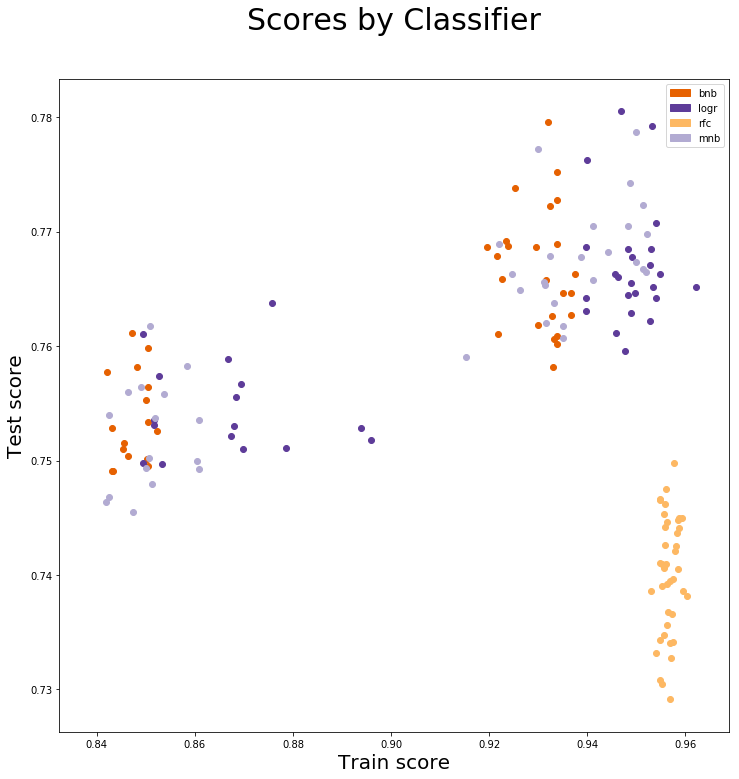

In [29]:
scores_df = pd.DataFrame(scores)

sorted_scores = scores_df.sort_values(
    by="test_score",
    ascending=False)

plt.figure(figsize=(12,12))
plt.title("Scores by Classifier", fontsize=30, pad=50)
plt.xlabel("Train score", fontsize=20)
plt.ylabel("Test score", fontsize=20)
handles = [mpatches.Patch(color=val, label=key) for key, val in color_map.items()]
plt.legend(handles=handles)
for key, val in color_map.items():
    for score in scores:
        if score["short_class"] == key:
            plt.scatter(
                x=score["train_score"],
                y=score["test_score"],
                color=val)
plt.savefig("../presentation/images/scores_by_classifier.png")
print()

Finally a look at the hyperparameters and classifiers that were the top 10

In [9]:
sorted_scores.head(10)

,classifier,short_class,test_score,train_score
30,"cvec__n_gram_range_of_(1, 3)_max_df_of0.25 usi...",logr,0.780554,0.946905
28,"cvec__n_gram_range_of_(1, 3)_max_df_of0.25 usi...",bnb,0.779549,0.932015
114,"tfidf__n_gram_range_of_(1, 4) using logr Class...",logr,0.779262,0.953224
113,"tfidf__n_gram_range_of_(1, 4) using mnb Classi...",mnb,0.778687,0.949969
29,"cvec__n_gram_range_of_(1, 3)_max_df_of0.25 usi...",mnb,0.777251,0.930004
50,"cvec__n_gram_range_of_(1, 2)_max_df_of0.5 usin...",logr,0.776246,0.939963
132,"tfidf__n_gram_range_of_(1, 3)_max_df_of0.5 usi...",bnb,0.775241,0.933834
133,"tfidf__n_gram_range_of_(1, 3)_max_df_of0.5 usi...",mnb,0.774235,0.948676
48,"cvec__n_gram_range_of_(1, 2)_max_df_of0.5 usin...",bnb,0.773804,0.925360
116,"tfidf__n_gram_range_of_(1, 4)_max_df_of0.25 us...",bnb,0.772799,0.933882
